# This tutorial describes how to use the Trust Region Bayesian Optimization algorithm, which is implemented in python.

Nina MOELLO ONERA/DTIS/M2CI - May 2020

<p class="alert alert-success" style="padding:1em">
To use TuRBO, please follow this link : https://github.com/uber-research/TuRBO. 
</p>

The reference paper is available 
here http://papers.nips.cc/paper/8788-scalable-global-optimization-via-local-bayesian-optimization 

This is the code-release for the TuRBO algorithm from Scalable Global Optimization via Local Bayesian Optimization appearing in NeurIPS 2019. This is an implementation for the noise-free case and may not work well if observations are noisy as the center of the trust region should be chosen based on the posterior mean in this case.

Note that TuRBO is a minimization algorithm, so please make sure you reformulate potential maximization problems.

TuRBO is cutting the space into trust regions and does independant local optimizations over these regions. Thus, turbo_1 does optimization over all the space (1 trust region) and turbo_m does it with m trust regions. 
This tutorial explain how to use turbo_m.py.


## Installing the requirements

The codes are written in python 3.6, so it is recommended to use this version of python to run the scripts. To install the requirements one can simply use this line:

The present code is available on Mac and Linux. For a Windows use, it needs compilation of other packages that are not precised in this notebook. 

Also, some test functions presented here depend on the smt package (https://github.com/SMTorg/smt) and the segolight package (on the ONERA SVN).

In [1]:
import math
import sys
from copy import deepcopy

import gpytorch
import numpy as np
import torch

from turbo.utils import from_unit_cube, latin_hypercube, to_unit_cube
from turbo.turbo_m import TurboM

## Set up an optimization problem class

### From analytical expression

In [2]:
class Levy:
    def __init__(self, dim=10):
        self.dim = dim
        self.lb = -5 * np.ones(dim)
        self.ub = 10 * np.ones(dim)
        
    def __call__(self, x):
        assert len(x) == self.dim
        assert x.ndim == 1
        assert np.all(x <= self.ub) and np.all(x >= self.lb)
        w = 1 + (x - 1.0) / 4.0
        val = np.sin(np.pi * w[0]) ** 2 + \
            np.sum((w[1:self.dim - 1] - 1) ** 2 * (1 + 10 * np.sin(np.pi * w[1:self.dim - 1] + 1) ** 2)) + \
            (w[self.dim - 1] - 1) ** 2 * (1 + np.sin(2 * np.pi * w[self.dim - 1])**2)
        return val

### From segolight

In [3]:
from sego.cases.high_mod_branin_prob import get_case as get_case_branin
from sego.cases.rover_60_prob import get_case as get_case_rov

class Branin:
    def __init__(self, dim=10): #dim 10, 20 or 100
        self.dim=dim
        self.lb=-1.0 * np.ones(dim)
        self.ub=1.0 * np.ones(dim)
        
    def __call__(self,x):
        assert len(x) == self.dim
        assert x.ndim == 1   
        assert np.all(x <= self.ub) and np.all(x >= self.lb)
        return  get_case_branin(self.dim)['f_obj'](x)[0]
    
class Rover:
    def __init__(self,dim=60):
        self.dim=dim
        self.lb=-1.0 * np.ones(dim)
        self.ub=1.0 * np.ones(dim)
        
    def __call__(self,x):
        assert len(x) == self.dim
        assert x.ndim == 1   
        assert np.all(x <= self.ub) and np.all(x >= self.lb)
        case_rov = get_case_rov()
        return case_rov['f_obj'](x)[0]  

## Create a TuRBO optimizer instance

In [4]:
fun = Levy(10)

turbo_m = TurboM(
    f=fun,  # Handle to objective function
    lb=fun.lb,  # Numpy array specifying lower bounds
    ub=fun.ub,  # Numpy array specifying upper bounds
    n_init=10,  # Number of initial bounds from an Symmetric Latin hypercube design
    max_evals=500,  # Maximum number of evaluations
    n_trust_regions=5,  # Number of trust regions
    batch_size=1,  # How large batch size TuRBO uses
    verbose=True,  # Print information from each batch
    use_ard=True,  # Set to true if you want to use ARD for the GP kernel
    max_cholesky_size=2000,  # When we switch from Cholesky to Lanczos
    n_training_steps=50,  # Number of steps of ADAM to learn the hypers
    min_cuda=1024,  # Run on the CPU for small datasets
    device="cpu",  # "cpu" or "cuda"
    dtype="float64",  # float64 or float32
)

Using dtype = torch.float64 
Using device = cpu


## Run the optimization process

In [5]:
turbo_m.optimize()

TR-0 starting from: 19.18
TR-1 starting from: 22.19
TR-2 starting from: 25.2
TR-3 starting from: 16.56
TR-4 starting from: 24.06
89) New best @ TR-4: 11.09
131) New best @ TR-4: 9.511
198) New best @ TR-4: 6.386


## Extract all evaluations from TuRBO and print the best

In [6]:
X = turbo_m.X  # Evaluated points
fX = turbo_m.fX  # Observed values
ind_best = np.argmin(fX)
f_best, x_best = fX[ind_best], X[ind_best, :]

print("Best value found:\n\tf(x) = %.3f\nObserved at:\n\tx = %s" % (f_best, np.around(x_best, 3)))

Best value found:
	f(x) = 6.386
Observed at:
	x = [ 0.601  0.56   1.38   3.967  3.977  0.919  3.107 -0.006 -3.781  2.356]


## Plot the result

TuRBO-5 converges to a solution close to the global optimum

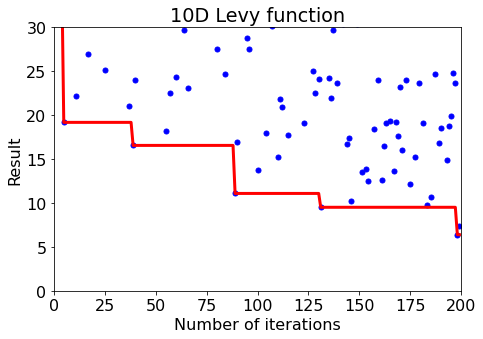

In [7]:
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7, 5))
matplotlib.rcParams.update({'font.size': 16})
plt.plot(fX, 'b.', ms=10)  # Plot all evaluated points as blue dots
plt.plot(np.minimum.accumulate(fX), 'r', lw=3)  # Plot cumulative minimum as a red line
plt.xlim([0, len(fX)])
plt.ylim([0, 30])
plt.xlabel('Number of iterations')
plt.ylabel('Result')
plt.title("10D Levy function")
plt.tight_layout()
plt.show() 